## Other Computer Vision Problems

### Multi-Label Classification

#### The Data

In [2]:
from fastai.vision.all import *

In [2]:
# download and untar some images
path = untar_data(URLs.PASCAL_2007)

In [3]:
# this time we have a file with the labels
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


#### Constructing a DataBlock

In [4]:
datablock = DataBlock()

In [5]:
datasets = datablock.datasets(df)

In [6]:
len(datasets.train), len(datasets.valid)

(4009, 1002)

In [7]:
# inspect first data item
x, y = datasets[0]
x, y

(fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object,
 fname       000005.jpg
 labels           chair
 is_valid          True
 Name: 0, dtype: object)

In [8]:
# constructing a data block with dependent and independent variables
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

datablock = DataBlock(get_x=get_x, get_y=get_y)
datasets = datablock.datasets(df)
datasets.train[0]

(Path('/storage/data/pascal_2007/train/008220.jpg'), ['train', 'person'])

In [9]:
# for converting the paths to images fastai has some help
datablock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     get_x=get_x, get_y=get_y)
datasets = datablock.datasets(df)
datasets.train[0]

(PILImage mode=RGB size=500x368,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0.]))

In [10]:
# see what the underlying vocab is
idxs = torch.where(datasets.train[0][1]==1.)[0]
datasets.train.vocab[idxs]

(#2) ['motorbike','person']

In [11]:
datasets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0.])

In [12]:
# because the validation samples are marked we use these
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [13]:
# now we add our same resizing to ensure all the images are the same size
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x, get_y=get_y,
                  item_tfms=RandomResizedCrop(128, min_scale=.35))
dls = dblock.dataloaders(df)

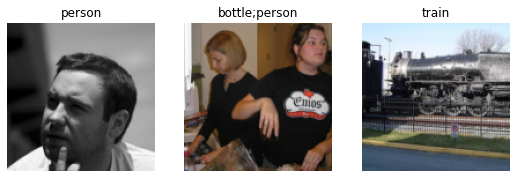

In [14]:
# inspect a batch
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [15]:
# instantiate a learner
learn = cnn_learner(dls, resnet18)

In [17]:
x, y = to_cpu(dls.train.one_batch())
activations = learn.model(x)
activations.shape

torch.Size([64, 20])

In [18]:
activations[0]

tensor([-0.2290,  0.6980, -0.5887,  4.9578,  4.9472,  2.3091, -0.7387,  0.4312,
        -3.7038,  1.6551,  1.6522, -2.3892, -4.7770,  2.5385, -1.8113, -1.9367,
         0.2219,  5.1945,  1.8042,  2.0094], grad_fn=<SelectBackward>)

In [19]:
# to use our mnist style loss we need to scale them between 0 and 1
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [20]:
# test our function
binary_cross_entropy(activations, y)

tensor(1.0853, grad_fn=<NegBackward>)

In [21]:
# and compare it to the pytorch one
nn.BCEWithLogitsLoss()(activations, y), \
    F.binary_cross_entropy_with_logits(activations, y)

(tensor(1.0853, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 tensor(1.0853, grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [22]:
# we also need a new metric for accuracy will not work
accuracy_multi??

### Metric Cutt-Off

In [23]:
# now we need to configure our metric limit
accuracy_multi_02 = partial(accuracy_multi, thresh=.2)

In [24]:
# and test our learner
learn = cnn_learner(dls, resnet50, metrics=accuracy_multi_02)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947006,0.683365,0.241076,00:12
1,0.828582,0.560960,0.284542,00:08
2,0.604793,0.203054,0.822629,00:08
3,0.362099,0.126664,0.937689,00:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.137907,0.120754,0.939821,00:10
1,0.118275,0.108733,0.951434,00:10
2,0.099242,0.103212,0.951474,00:10


In [25]:
# now we can also change our metric and evaluate again
learn.metrics = partial(accuracy_multi, thresh=.1)
learn.validate()

(#2) [0.10321152210235596,0.9302590489387512]

In [26]:
# this result is clearly wrong so we try a bunch of
preds, targs = learn.get_preds()

In [32]:
len(dls.valid.dataset), len(preds)

(2510, 2510)

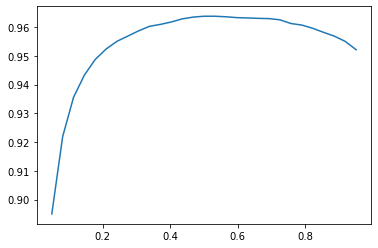

In [33]:
xs = torch.linspace(.05, .95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

The highest point on the graph is around .5 so we might be choosing this for inference. No, its not a problem that we're doing this on the validation set since the curve is smooth hence were not overfitting.


*Jeremy: This is a good example of where you have to be careful of the difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) versus practice (if the relationship is smooth, then it's fine to do this).*

## Regression

We're trying to predict two floats for locating the center of the face in an image.

In [4]:
# get some kinect data
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [7]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [8]:
# get all images files
images = get_image_files(path)

In [14]:
# function for getting pose file from image
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

# test it
img2pose(images[0])

Path('07/frame_00387_pose.txt')

In [21]:
sample = PILImage.create(images[0])
sample.shape

(480, 640)

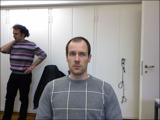

In [23]:
sample.to_thumb(160)

In [24]:
# the function for extracting the coordinates - not important here
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [25]:
get_ctr(images[0])

tensor([318.8099, 230.5128])

In [26]:
# create a function that excludes one person for validation
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

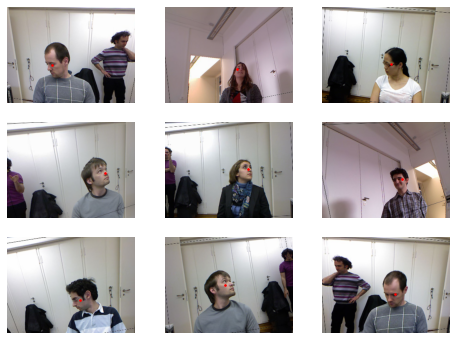

In [27]:
# look at our data
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [28]:
# inspect our data
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [29]:
# the dependent variable is a coordinate
yb[0]

tensor([[0.0854, 0.0247]], device='cuda:0')

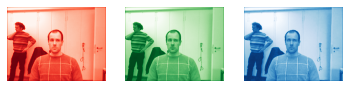

In [38]:
_, axes = plt.subplots(1,3)
im = image2tensor(sample)
for channel, ax, color in zip(im, axes, ('Reds', 'Greens', 'Blues')):
    show_image(255-channel, ax=ax, cmap=color)

In [39]:
# and the independent variable is a image with the color channels
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

In [41]:
# we borrow the plot_function from the fastbook library
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

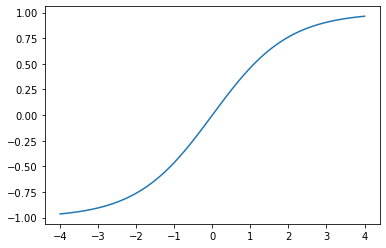

In [44]:
# the mapping to y_range is done via the sigmoid range function
plot_function(partial(sigmoid_range, low=-1, high=1), min=-4, max=4)

In [45]:
# see what our dataloader choose as a loss function
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=7.585775847473997e-07)

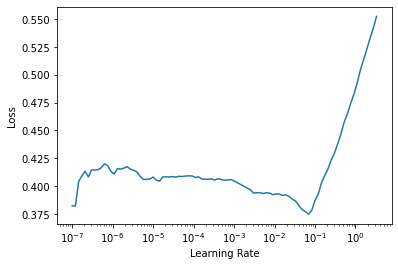

In [46]:
# use our learning rate finder
learn.lr_find()

In [47]:
# according to our rule we take one order of magnitude below the minima
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.051569,0.041167,00:54


epoch,train_loss,valid_loss,time
0,0.009064,0.002956,00:59
1,0.003261,0.000212,00:58
2,0.001463,0.000036,00:58


In [48]:
# since its the mean squared error we take the root
math.sqrt(.000036)

0.006

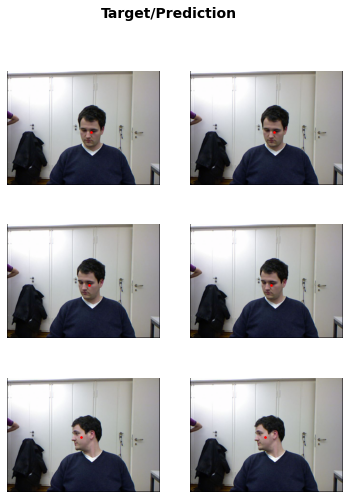

In [51]:
# validate our result with what we see
learn.show_results(ds_idx=1, nrows=3, figsize=(6, 8))